### Helpers

In [70]:
#Packages for NLP
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import re

nlp = spacy.load("en_core_web_sm")

In [ ]:
# #from EDA notebook

In [ ]:
# Functions for cleaning

In [115]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','em', 'haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh']

In [114]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [116]:
def concat_songs(list_lyrics):
    combo = ' '.join(lyric for lyric in list_lyrics)
    return combo

In [117]:
def get_tokens(songs, remove_stop_words=True):
    """Splits a string of text into individual words and transform some bad languages"""
    #remove stop words
    stop_words = set(stopwords_list) if remove_stop_words else []
    #tokenize
    words = [x for x in songs.split() if x not in stop_words]
    words = ['Nword' if x in ['nigga', 'niggas','n*gga','n*ggas'] else x for x in words]
    words = ['Fword' if x in ['fuck', 'fucking','fuckin','fuckin\'','fucker','motherfucker','motherfucking','mothafuck', 
                              'mothafucka', 'mothafuckas', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking',
                             'fuckers', 'motherfuck','mother fuckers','motherfuck', 'motherfucka', 'motherfuckas', 
                              'motherfucker','motherfuckers','motherfuckin','motherfucking'] else x for x in words]
    words = ['Bword' if x in ['bitch', 'bitch ', 'ho','hoes','b*tch','bitches', 'bitchin'] else x for x in words]
    return words

In [118]:
#replace in' with ing and digits
def replace_contraction(list_lyrics):
    result = []
    for lyric in list_lyrics:
        lyric = re.sub(r'[0-9]', '# ',lyric)
        lyric = lyric.replace("in\'","ing")
        lyric = lyric.replace("# pac","2Pac")
        lyric = lyric.replace("# Pac","2Pac")
        lyric = lyric.replace("# chainz","2Chainz")
        lyric = lyric.replace("# Chainz","2Chainz")
        result.append(lyric)
    return result

In [120]:
def lem_words(list_of_tokens,pos): 
    wrd_list = [Word(word).lemmatize(pos=pos) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return wrd_list

In [121]:
#function to create wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [122]:
#Function to create the correlation heatmap
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

In [123]:
#Function to classify music by decades
def get_decade(year):
    decade = ''
    if year >=1980 and year <1990:
        decade = '1980-90s'
    elif year >=1990 and year <2000:
        decade = '1990-00s'
    elif year >=2000 and year <2010:
        decade = '2000-10s'
    elif year >=2010 and year <2020:
        decade = '2010-20s'
    else:
        decade = 'Other'
    return decade

## Getting dataframes & Cleaning

In [124]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [125]:
print(df.shape)
df.head()

(27120, 22)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,"[haha, big, # # , know, Fword, going, ayy, kno...","[haha, big, # # , know, Fword, go, ayy, know, ...",168
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",464
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",327
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",309


In [29]:
#drop columns not nedeed for clustering
df = df.drop(columns=['Album','Title','duration_ms','tokens','tokens_lemma'])

In [30]:
df.shape #(27514, 17)

(27514, 17)

In [31]:
# get rid of lyrics with less than 25 words
df.drop(df[df['Cleaned_lyrics'].str.len() < 25].index, inplace=True)

In [32]:
df.shape

(27504, 17)

In [33]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309


In [34]:
#remove stop words and create token
df['tokens'] = df.Cleaned_lyrics.apply(lambda x: get_tokens(x))

In [35]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168,"[haha, big, 14, know, Fword, going, ayy, know,..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309,"[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [36]:
#few more cleaning
df['tokens'] = df.tokens.apply(lambda x: replace_contraction(x))

In [37]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168,"[haha, big, # # , know, Fword, going, ayy, kno..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309,"[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [41]:
#Lemmatize for nouns
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'n'))

In [43]:
#Lemmatize for verbs
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'v'))

In [44]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168,"[haha, big, # # , know, Fword, going, ayy, kno...","[haha, big, # # , know, Fword, go, ayy, know, ..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [45]:
df['working_lyrics'] = df.lemmatized_lyrics.apply(lambda x: concat_songs(x))

In [46]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168,"[haha, big, # # , know, Fword, going, ayy, kno...","[haha, big, # # , know, Fword, go, ayy, know, ...",haha big # # know Fword go ayy know keep cand...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...


## Most frequent words

### All Lyrics

In [ ]:
#Functions to count top words and plots the frequency (from https://github.com/h-parker/commencement-speech-generator/blob/master/nlp-eda.ipynb)

In [47]:
def get_top_n_words(ngram_start, ngram_end, corpus, n=10):
    """
    List the top n words in a vocabulary according to occurrence in corpus.
    """
    vec = CountVectorizer(ngram_range = (ngram_start, ngram_end))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [48]:
def plot_top_n_ngrams(corpus, n, ngram_start, ngram_end):
    """
    Given corpus, number of top words you want, the range of 
    ngrams you're interested in (eg, just words: start = 1, end=1;
    words & bigrams: start=1, end=2), this function will graph the
    top words/ngrams in your corpus.
    """
    # get top n words
    top_words = get_top_n_words(ngram_start, ngram_end, corpus, n)
    
    # plot top n words
    fig = plt.figure(figsize=(12,6))
    ax = plt.barh([x[0] for x in top_words], [y[1] for y in top_words], 
            align='center', alpha=0.5,color='r')
    plt.title('Distribution of most frequent words')
    plt.xlabel('# times')
    plt.ylabel('Words')



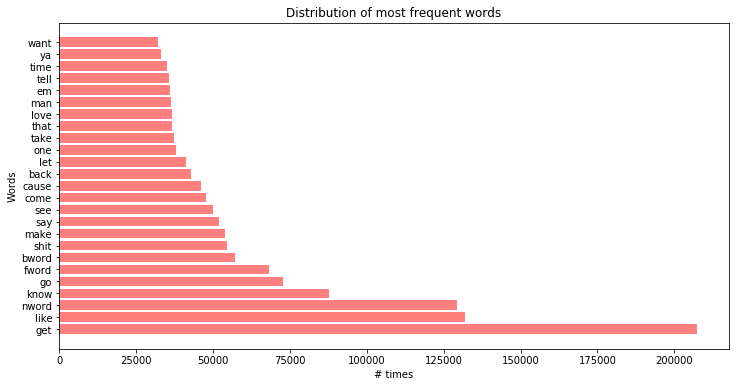

In [50]:
plot_top_n_ngrams(df.working_lyrics, 25, 1, 1)

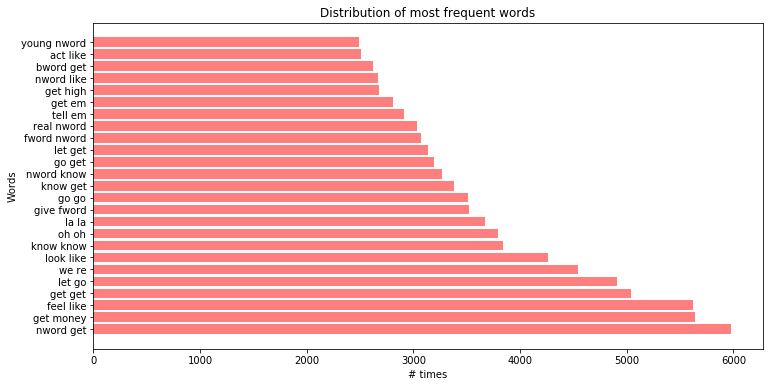

In [51]:
plot_top_n_ngrams(df.working_lyrics, 25, 2, 2)

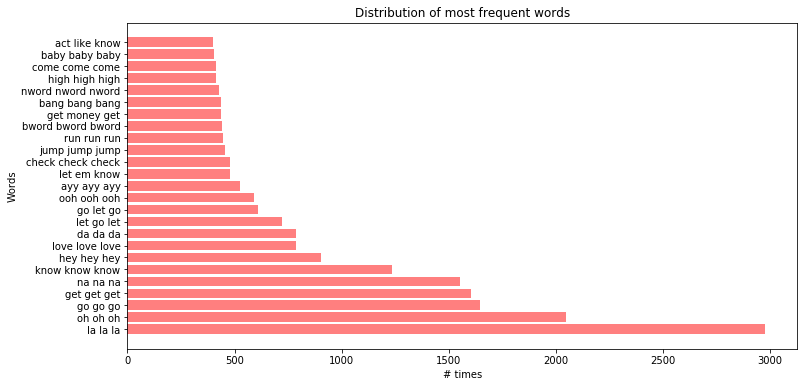

In [52]:
plot_top_n_ngrams(df.working_lyrics, 25, 3, 3)

## Vectorize

### TF IDF

In [53]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,168,"[haha, big, # # , know, Fword, going, ayy, kno...","[haha, big, # # , know, Fword, go, ayy, know, ...",haha big # # know Fword go ayy know keep cand...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,464,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,327,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,309,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...


In [54]:
len(df) #27504

27504

In [ ]:
#Create a list with all the lyrics from the tokens serie
list_lyrics = df.tokens_lemma.tolist()

In [ ]:
len(list_lyrics)

In [ ]:
# I have a list of list - I want to have a list of string
final_list_lyrics = []
for row in list_lyrics:
    if type(row) == list:
        final_list_lyrics.extend(row)

In [ ]:
len(final_list_lyrics) #7962878

In [ ]:
final_list_lyrics[:5]

In [ ]:
#Lemmatize again
final_list_lyrics = lem_words(final_list_lyrics)

In [ ]:
len(final_list_lyrics)

after preparing the list of words - vectorize time

In [55]:
#max_df --> ignore words that appear in 90% of the songs 
#ignores words that occur in fewer than 25 songs - use my created stopword list
# I am not interested in more than 75k features
vectorizer = TfidfVectorizer(max_df=0.9, max_features=75000,
                             min_df=25, stop_words=stopwords_list,
                             use_idf=True, ngram_range=(1, 3))

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.9, max_features=75000,
                             min_df=25, stop_words=stopwords_list,
                             use_idf=True, ngram_range=(1, 3))

In [60]:
#using TF-IDF to vectorize 
lyrics_tfidf = vectorizer.fit_transform(df['working_lyrics'])

In [67]:
print(vectorizer.get_feature_names())

['2pac', '2pac biggie', 'aa', 'aaah', 'aah', 'aaliyah', 'aap', 'aaron', 'ab', 'abandon', 'abc', 'abdomen', 'abduct', 'abel', 'abide', 'ability', 'able', 'aboard', 'abort', 'abortion', 'abortions', 'abracadabra', 'abraham', 'abroad', 'abs', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'abstract', 'absurd', 'abundance', 'abuse', 'abusive', 'aby', 'ac', 'academy', 'acapella', 'accelerate', 'accent', 'accept', 'acceptance', 'access', 'accident', 'accidentally', 'accolades', 'accompany', 'accomplish', 'accomplishments', 'accord', 'accordingly', 'account', 'accountant', 'accountants', 'accumulate', 'accurate', 'accuse', 'accustom', 'ace', 'ace hood', 'ace spade', 'ache', 'achieve', 'acid', 'acknowledge', 'acne', 'acquaint', 'acquire', 'acquit', 'acre', 'acres', 'acrobat', 'acrobatic', 'across', 'across globe', 'across room', 'across street', 'across world', 'act', 'act ass', 'act bad', 'act brand', 'act brand new', 'act crazy', 'act different', 'act dumb', 'act fool', 'act funny'

In [61]:
#Checking the shape of my vectorizer
print(lyrics_tfidf.shape)

(27504, 37053)


In [62]:
vect_df = pd.DataFrame(lyrics_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [63]:
vect_df.head()

,2pac,2pac biggie,aa,aaah,aah,aaliyah,aap,aaron,ab,abandon,...,zone get,zone like,zone nword,zone zone,zoo,zoom,zoom zoom,zooted,zro,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
vect_df.shape

(27504, 37053)

## Transformation LSA and LDA

In [103]:
from sklearn.decomposition import TruncatedSVD
# init svd
svd = TruncatedSVD(n_components=5000, random_state=43)
lsa = make_pipeline(svd, Normalizer(copy=False))

In [105]:
# run svd
lyrics_lsa = lsa.fit_transform(lyrics_tfidf)

In [104]:
sum(svd.explained_variance_ratio_[0:5000])

AttributeError: 'TruncatedSVD' object has no attribute 'explained_variance_ratio_'

In [101]:
lyrics_lsa.shape

(27504, 5000)

In [102]:
#Trying to understand the components
from pylab import *

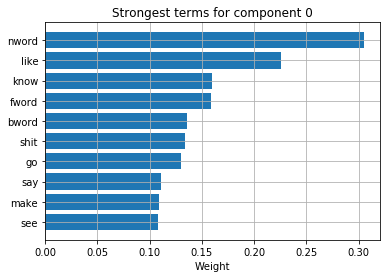

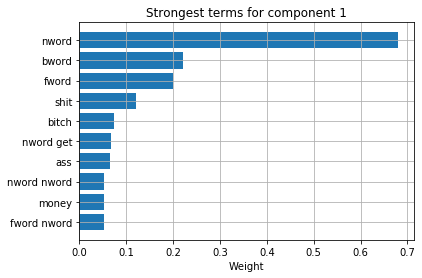

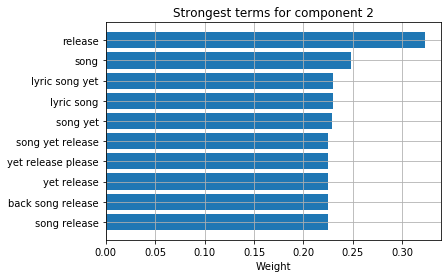

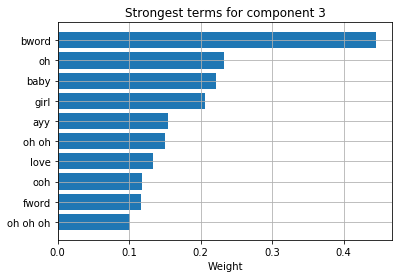

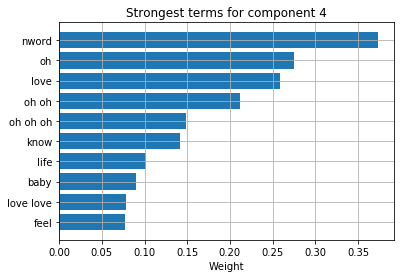

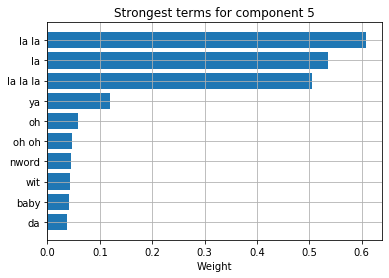

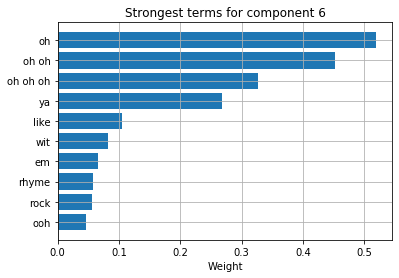

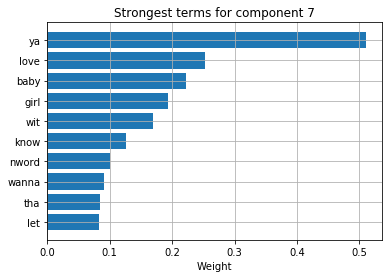

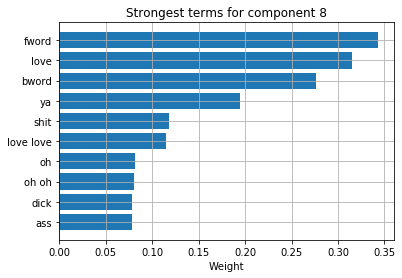

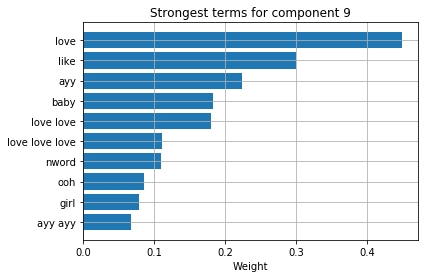

In [107]:
# taken from https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    feat_names = vectorizer.get_feature_names()
    
    # Sort the weights in the first component, and get the indeces
    indices = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indices.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()